In [30]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import random
import torch.nn.functional as F
from torchmetrics.functional.image.ssim import (
    structural_similarity_index_measure,
)
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [31]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [32]:
def resize_encoder(sample):
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample


def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDatasetWindow(Dataset):
    def __init__(
        self,
        data,
        context_length,
        target_length,
        stride=1,
        mask_prob_low=0.7,
        mask_prob_high=0.7,
    ):
        self.data = data
        self.context_length = context_length
        self.target_length = target_length
        self.stride = stride
        self.mask_prob_low = mask_prob_low
        self.mask_prob_high = mask_prob_high

    def __len__(self):
        return (
            self.data.shape[0] - (self.context_length + self.target_length)
        ) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end_context = start + self.context_length
        end_target = end_context + self.target_length
        x = random_mask(
            resize_encoder(self.data[start:end_context]),
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        y = self.data[end_context:end_target]
        y_masked = random_mask(
            resize_encoder(y),
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        return x, y_masked, y

In [33]:
seq2seq_model = torch.load(
    "downstream_model_no_decoder_weight_decay_s_10_cw_5.pth",
    weights_only=False,
    map_location=DEVICE,
)
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)

model.eval()
seq2seq_model.eval()

OUTPUT_LEN = 100
CONTEXT_WINDOW = 5
STRIDE = 10

seq2seq_model.output_len = OUTPUT_LEN

encoder_model = model.model.encoder
decoder_model = model.decoder


data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]


BATCH_SIZE = 16
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

In [34]:
def prepare_inputs(input_data, output_data, encoder_model):
    B, T, C, H, W = input_data.shape
    input_data = input_data.reshape(B * T, C, H, W)
    input_encoded_data, _ = encoder_model(input_data)

    input_encoded_data = input_encoded_data.reshape(B, T, -1)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B * T, C, H, W)

    output_encoded_data = encoder_model(output_data)[0]
    output_encoded_data = output_encoded_data.reshape(B, T, -1)
    return input_encoded_data, output_encoded_data

In [35]:
def compute_error(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    teacher_forcing=False,
):
    mse_loss = torch.nn.MSELoss(reduction="none")
    mse = []
    latent_mse = []
    ssim = []
    psnr = []
    for batch in testloader:
        with torch.no_grad():
            input_data = batch[0].to(DEVICE)
            output_data_masked = batch[1].to(DEVICE)
            output_data = batch[2].to(DEVICE)
            input_encoded_data, output_encoded_data = prepare_inputs(
                input_data, output_data_masked, encoder_model
            )
            if teacher_forcing:
                model_pred = seq2seq_model(
                    input_encoded_data, output_encoded_data, eps=1.0
                )
            else:
                model_pred = seq2seq_model(input_encoded_data)
            if model_pred.ndim == 2:
                model_pred = model_pred.unsqueeze(0)
            B, T, L = model_pred.shape
            model_pred = model_pred.reshape(B * T, L)
            output_encoded_data = output_encoded_data.reshape(B * T, L)
            decoded_data = decoder_model(model_pred)
            B, T, C, H, W = output_data.shape
            decoded_data = decoded_data.reshape(B, T, C, H, W)

            model_pred = model_pred.reshape(B, T, L)
            output_encoded_data = output_encoded_data.reshape(B, T, L)

            latent_mse_l = mse_loss(model_pred, output_encoded_data)
            latent_mse_l = latent_mse_l.mean(dim=(0, 2)).cpu().numpy()

            mse_l = mse_loss(decoded_data, output_data)
            mse_l = mse_l.mean(dim=(0, 2, 3, 4)).cpu().numpy()

            decoded_data_ = decoded_data.reshape(B * T, C, H, W)
            output_data_ = output_data.reshape(B * T, C, H, W)
            mean = mean.to(DEVICE)
            std = std.to(DEVICE)
            decoded_data_ = decoded_data_ * std + mean
            output_data_ = output_data_ * std + mean

            x_min = train_data.amin(dim=(0, 2, 3), keepdim=True).to(DEVICE)
            x_max = train_data.amax(dim=(0, 2, 3), keepdim=True).to(DEVICE)

            decoded_data_ = (decoded_data_ - x_min) / (x_max - x_min + 1e-8)
            output_data_ = (output_data_ - x_min) / (x_max - x_min + 1e-8)

            ssim_l = structural_similarity_index_measure(
                decoded_data_, output_data_, data_range=1.0, reduction=None
            )
            psnr_l = peak_signal_noise_ratio(
                decoded_data_,
                output_data_,
                reduction=None,
                data_range=1.0,
                dim=[1, 2, 3],
            )

            ssim_l = ssim_l.reshape(B, T).mean(0).cpu().numpy()
            psnr_l = psnr_l.reshape(B, T).mean(0).cpu().numpy()

            mse.append(mse_l)
            latent_mse.append(latent_mse_l)
            ssim.append(ssim_l)
            psnr.append(psnr_l)

    # print(f"MSE Loss: {np.mean(mse, axis=0)}")
    # print(f"Masked Normalised SSIM Loss: {np.mean(ssim, axis=0)}")
    # print(f"Masked Normalised PSNR Loss: {np.mean(psnr, axis=0)}")
    mse_time = np.mean(mse, axis=0)
    latent_mse_time = np.mean(latent_mse, axis=0)
    ssim_time = np.mean(ssim, axis=0)
    psnr_time = np.mean(psnr, axis=0)
    mse_thresh = 1.2 * mse_time[0]
    latent_mse_thresh = 1.2 * latent_mse_time[0]
    ssim_thresh = 0.8 * ssim_time[0]
    psnr_thresh = 0.8 * psnr_time[0]
    timesteps = np.arange(len(mse_time))
    print(mse_time[49])
    print(mse_time[-1])

    fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

    axes[0].plot(timesteps, mse_time, label="Decoded MSE", color="blue")
    axes[0].axhline(
        y=mse_thresh,
        color="red",
        linestyle="--",
        label="20% above starting value",
    )
    axes[0].set_ylabel("Decoded MSE")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(timesteps, latent_mse_time, label="Latent MSE", color="blue")
    axes[1].axhline(
        y=latent_mse_thresh,
        color="red",
        linestyle="--",
        label="20% above starting value",
    )
    axes[1].set_ylabel("Latent MSE")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(timesteps, ssim_time, label="SSIM", color="green")
    axes[2].axhline(
        y=ssim_thresh,
        color="red",
        linestyle="--",
        label="20% below starting value",
    )
    axes[2].set_ylabel("SSIM")
    axes[2].legend()
    axes[2].grid(True)

    axes[3].plot(timesteps, psnr_time, label="PSNR", color="orange")
    axes[3].axhline(
        y=psnr_thresh,
        color="red",
        linestyle="--",
        label="20% below starting value",
    )
    axes[3].set_ylabel("PSNR")
    axes[3].set_xlabel("Time step")
    axes[3].legend()
    axes[3].grid(True)

    for ax in axes:
        ax.set_xticks(timesteps)

    mse_cross = np.argmax(mse_time > mse_thresh)
    ssim_cross = np.argmax(ssim_time < ssim_thresh)
    psnr_cross = np.argmax(psnr_time < psnr_thresh)
    axes[0].axvline(
        x=mse_cross, color="purple", linestyle=":", label="Threshold crossed"
    )
    axes[1].axvline(
        x=ssim_cross, color="purple", linestyle=":", label="Threshold crossed"
    )
    axes[2].axvline(
        x=psnr_cross, color="purple", linestyle=":", label="Threshold crossed"
    )

    plt.suptitle("Metrics Over Time with 20% Threshold Lines")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [36]:
test_dataset = WeatherBenchDatasetWindow(
    data=test_data,
    context_length=CONTEXT_WINDOW,
    target_length=OUTPUT_LEN,
    stride=STRIDE,
    mask_prob_low=0.7,
    mask_prob_high=0.7,
)
testloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g
)

0.8538768
0.89907235


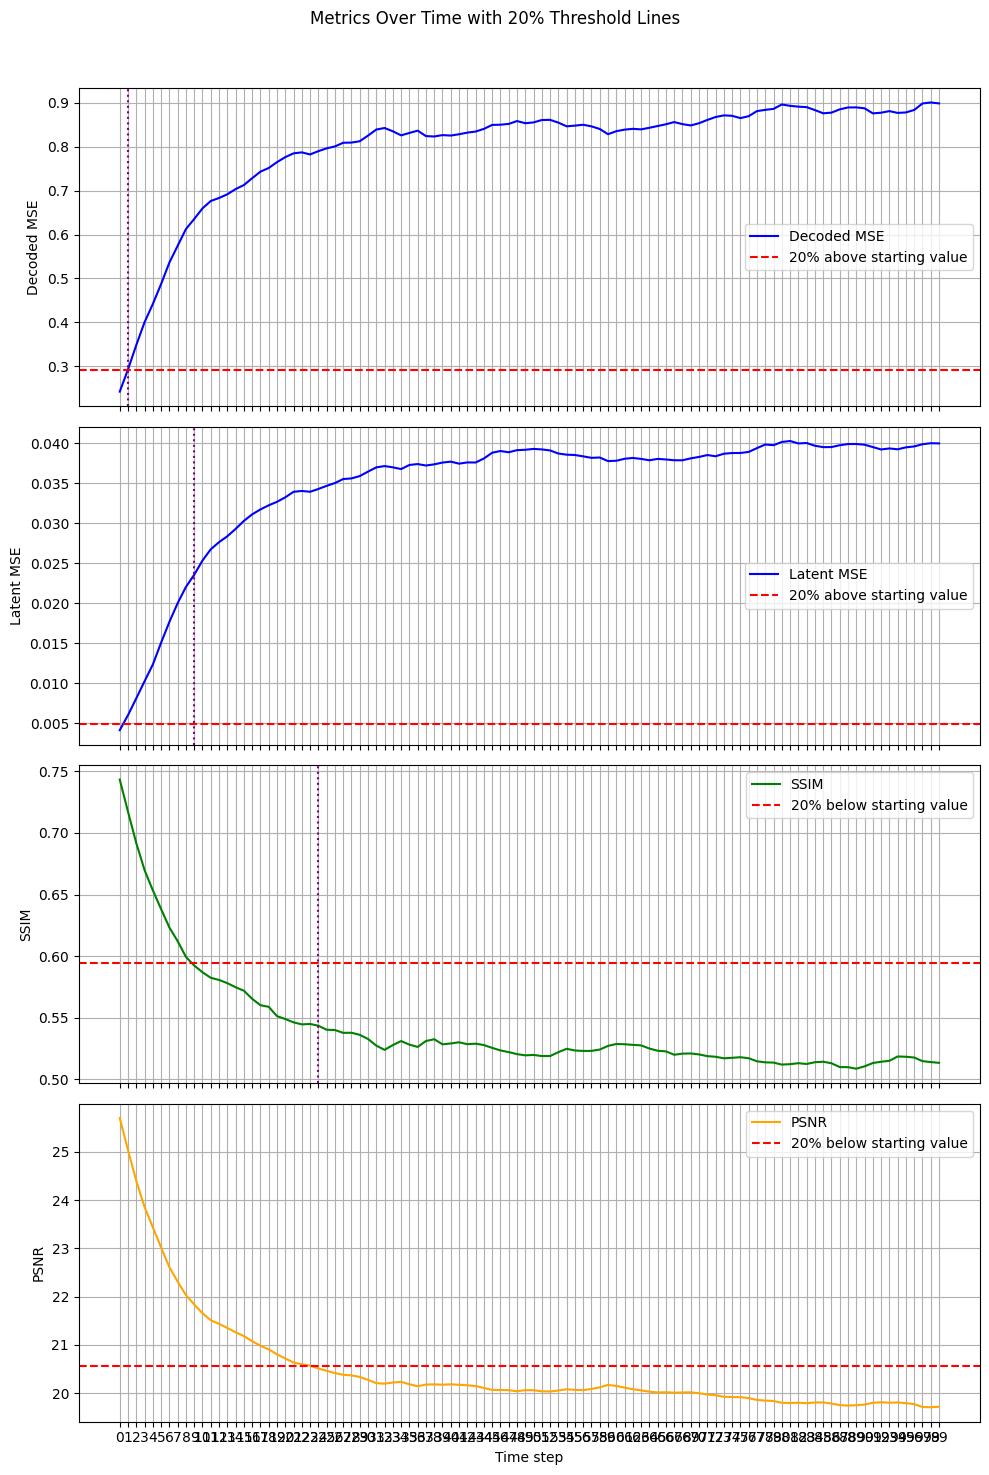

In [37]:
compute_error(
    testloader,
    encoder_model,
    seq2seq_model,
    decoder_model,
    std,
    mean,
    train_data,
    teacher_forcing=False,
)

In [38]:
batch = next(iter(testloader))
input_data = batch[0].to(DEVICE)
output_data_masked = batch[1].to(DEVICE)
output_data = batch[2].to(DEVICE)

In [39]:
with torch.no_grad():
    input_encoded_data, output_encoded_data = prepare_inputs(
        input_data, output_data_masked, encoder_model
    )
    model_pred = seq2seq_model(input_encoded_data)
    if model_pred.ndim == 2:
        model_pred = model_pred.unsqueeze(0)
    B, T, L = model_pred.shape
    model_pred = model_pred.reshape(B * T, L)
    output_encoded_data = output_encoded_data.reshape(B * T, L)
    decoded_data = decoder_model(model_pred)
    B, T, C, H, W = output_data.shape
    decoded_data = decoded_data.reshape(B, T, C, H, W)
    print(decoded_data.shape)

torch.Size([16, 100, 5, 64, 32])


In [40]:
output_encoded_data = output_encoded_data.reshape(B, T, L)
model_pred = model_pred.reshape(B, T, L)

In [41]:
output_encoded_data_np = output_encoded_data[0].cpu().numpy()
model_pred_np = model_pred[0].cpu().numpy()
combined = np.vstack([model_pred_np, output_encoded_data_np])
pca = PCA(n_components=2)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined)

combined_proj = pca.fit_transform(combined_scaled)

/tmp/ipykernel_2881011/2560876563.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


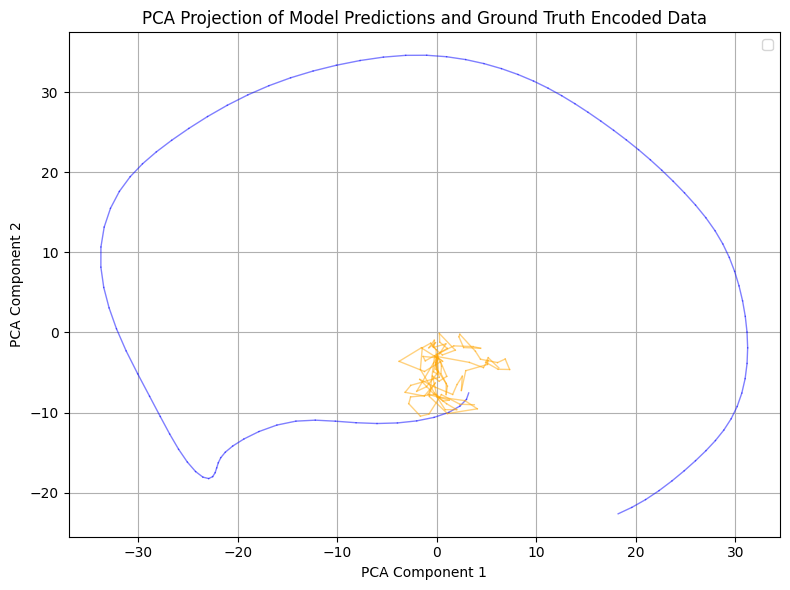

In [42]:
n_pred = model_pred_np.shape[0]

model_pred_proj = combined_proj[:n_pred]
encoded_data_proj = combined_proj[n_pred:]

plt.figure(figsize=(8, 6))
for i in range(n_pred - 1):
    plt.plot(
        [model_pred_proj[i, 0], model_pred_proj[i + 1, 0]],
        [model_pred_proj[i, 1], model_pred_proj[i + 1, 1]],
        color="blue",
        alpha=0.5,
        linewidth=1,
    )

for i in range(n_pred - 1):
    plt.plot(
        [encoded_data_proj[i, 0], encoded_data_proj[i + 1, 0]],
        [encoded_data_proj[i, 1], encoded_data_proj[i + 1, 1]],
        color="orange",
        alpha=0.5,
        linewidth=1,
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Model Predictions and Ground Truth Encoded Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

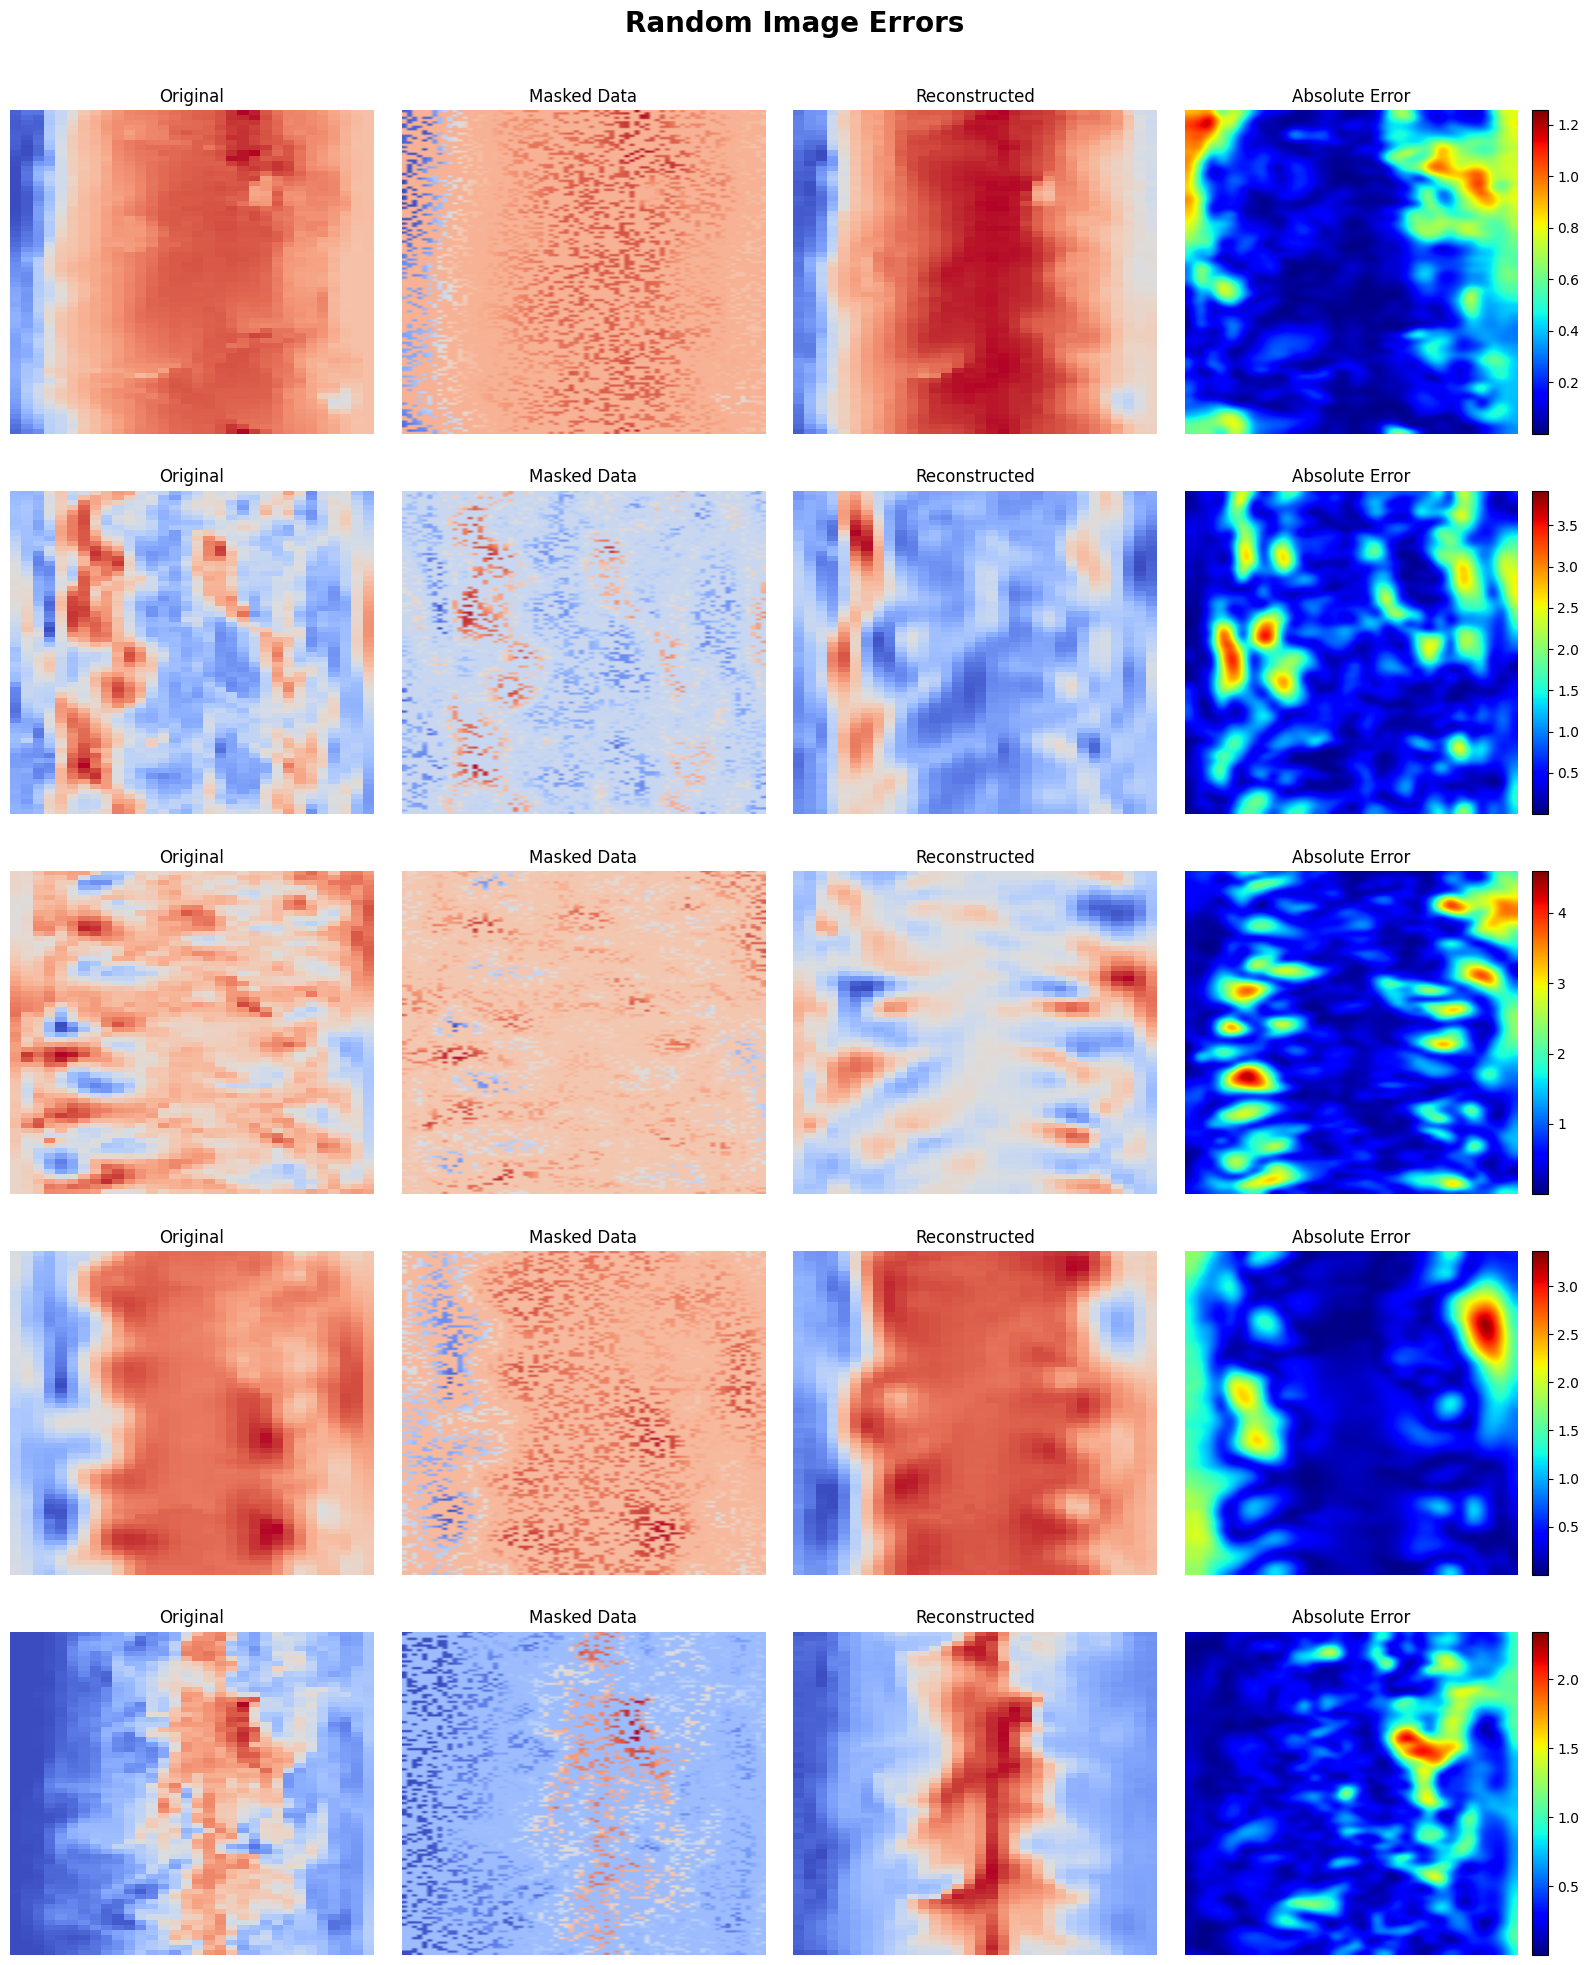

: 

In [ ]:
x_temp = (
    output_data[0, -1, :, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()
)

masked_x_temp = (
    output_data_masked[0, -1, :, :, :]
    .unsqueeze(1)
    .permute(0, 2, 3, 1)
    .cpu()
    .numpy()
)
recon_masked_x_temp = (
    decoded_data[0, -1, :, :, :]
    .unsqueeze(1)
    .permute(0, 2, 3, 1)
    .cpu()
    .numpy()
)
error = np.abs(x_temp - recon_masked_x_temp)

fig, axs = plt.subplots(5, 4, figsize=(16, 20))
for i in range(5):
    x_temp_i = x_temp[i]
    masked_x_temp_i = masked_x_temp[i]
    recon_masked_x_temp_i = recon_masked_x_temp[i]
    error_i = error[i]

    axs[i, 0].imshow(x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 1].set_title("Masked Data")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(recon_masked_x_temp_i, cmap="coolwarm", aspect="auto")
    axs[i, 2].set_title("Reconstructed")
    axs[i, 2].axis("off")

    im = axs[i, 3].imshow(
        error_i, cmap="jet", aspect="auto", interpolation="bicubic"
    )
    axs[i, 3].set_title("Absolute Error")
    axs[i, 3].axis("off")

    fig.colorbar(im, ax=axs[i, 3], fraction=0.046, pad=0.04)
fig.suptitle("Random Image Errors", fontsize=20, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()